In [4]:
import os
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, TensorDataset
import pytorch_lightning as pl
import scipy.stats as ss

import numpy as np

from tqdm.notebook import trange

import matplotlib.pyplot as plt

# Data Generating Process

In [5]:
def bootstrap(arrs,size):
    
    indices = np.random.choice(np.arange(len(x)),size)
    return x[indices]

In [36]:
DIM = 1
OFFSET= 2
NUM_UNLABELED = 10000
NUM_LABELED = 1000
COV = 1
ZCOV= np.eye(DIM)
def genData():
    # UNLABELED
    pi = .5
    mu_1,mu_2 = np.zeros(DIM) + OFFSET, np.zeros(DIM) - OFFSET
    y = np.random.binomial(1,pi,size=NUM_UNLABELED).astype(bool)
    z = np.zeros((NUM_UNLABELED,DIM))
    z[y] = np.random.multivariate_normal(mu_1,ZCOV,size=y.sum())
    z[~y] = np.random.multivariate_normal(mu_2,ZCOV,size=y.shape[0] - y.sum())
    x = torch.normal(torch.Tensor(z),COV)
    # POSITIVE
    zp = np.random.multivariate_normal(mu_1,np.eye(DIM),size=NUM_LABELED)
    xp = torch.normal(torch.Tensor(zp),1)
    posIndices = np.random.choice(np.arange(len(xp)),NUM_UNLABELED)
    xp = xp[posIndices]
    zp = zp[posIndices]
    return xp,x,torch.Tensor(zp),torch.Tensor(z)

In [17]:
dl = DataLoader(TensorDataset(*genData()),batch_size=1024,)

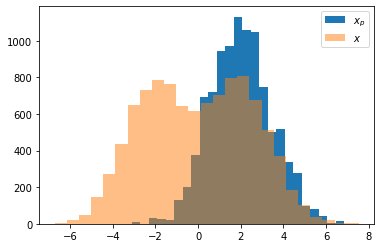

In [29]:
plt.hist(dl.dataset.tensors[0].numpy().ravel(),bins=25,label=r"$x_p$")
plt.hist(dl.dataset.tensors[1].numpy().ravel(),alpha=.5,bins=25,label=r"$x$")
plt.legend()

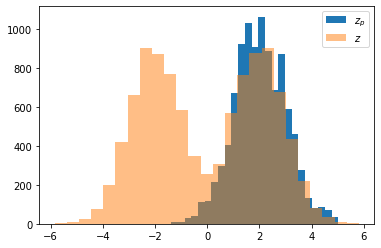

In [30]:
plt.hist(dl.dataset.tensors[2].numpy().ravel(),bins=25,label=r"$z_p$")
plt.hist(dl.dataset.tensors[3].numpy().ravel(),alpha=.5,bins=25,label=r"$z$")
plt.legend()

In [31]:
import pdb

In [32]:
import numpy as np

In [39]:
elboUS = []
elboPS = []
PIS = []
class PUVAE(pl.LightningModule):
    def __init__(self,input_dim, h_dim, z_dim,COV,ZCOV,EMSTEPS=10,JOINT_EM=True):
        super().__init__()
        self.encoder = nn.Sequential(nn.Linear(input_dim, h_dim),nn.ReLU(),
                                     nn.Linear(h_dim, h_dim),nn.ReLU(),
                                     nn.Linear(h_dim, h_dim),nn.ReLU())
        self.mu_encoder = nn.Sequential(nn.Linear(h_dim, z_dim))
        self.cov_encoder = nn.Sequential(nn.Linear(h_dim, z_dim))
        self.decoder = nn.Sequential(nn.Linear(z_dim, h_dim), nn.ReLU(),
                                     nn.Linear(h_dim, h_dim), nn.ReLU(),
                                     nn.Linear(h_dim, input_dim))
        self.pi = torch.ones(1) * .5
        self.mu = torch.randn(2,z_dim) 
        self.z_dim = z_dim
        self.EMSTEPS = EMSTEPS
        self.COV = COV
        self.ZCOV = ZCOV
        self.JOINT_EM= JOINT_EM

    def forward(self, x):
        N = x.shape[0]
        h = self.encoder(x)
        mu = self.mu_encoder(h)
        sigma = torch.exp(self.cov_encoder(h))
        eps = torch.randn(*mu.shape)
        z= eps * sigma + mu
        return z, self.decoder(z)

    def training_step(self, batch, batch_idx):
        # separate positive and unlabeled
        xP, x,trueZP,trueZ = batch
        ######### Sample from q(z|x) ############
        h = self.encoder(x)
        mu = self.mu_encoder(h)
        sigma = torch.exp(self.cov_encoder(h))
        eps = torch.randn(*mu.shape,)
        z = eps * sigma + mu
        ######### Sample from q(z|xp) ##########
        hP = self.encoder(xP)
        muP = self.mu_encoder(hP)
        sigmaP = torch.exp(self.cov_encoder(hP))
        epsP = torch.randn(*muP.shape)
        zP = epsP * sigmaP + muP
        ####### Calculate q(z|x) ###############
        n = torch.distributions.Normal(mu,sigma)
        qzx = n.log_prob(z).sum(-1)
        ####### Calculate q(zP|xP) ###############
        nP = torch.distributions.Normal(muP,sigmaP)
        qzPxP = nP.log_prob(zP).sum(-1)
        ###### Calculate p(x|z) ###############
        xHat = self.decoder(z)
        n1 = torch.distributions.Normal(xHat, self.COV)
        pxz = n1.log_prob(xHat).sum(-1)
        ###### Calculate p(xP|zP) ###############
        xPHat = self.decoder(zP)
        n1P = torch.distributions.Normal(xPHat, self.COV)
        pxPzP = n1P.log_prob(xPHat).sum(-1)
        ################# DEBUG PLOTS #################
#         fig,ax = plt.subplots(2,1)
# #         fig.set_facecolor("white")
#         ax[0].hist(z.detach().numpy().ravel())
#         ax[1].hist(xHat.detach().numpy().ravel())
#         fig.tight_layout()
#         plt.show()
        ########## EM-Steps ###################
        # two options either include labeled data (and fix gammas) or exclude as is done below
        delta = 1e-5
        if self.JOINT_EM:
            zd = torch.concat([z, zP]).detach()
        else:
            zd = z.detach()
        for em_step in range(self.EMSTEPS):
            #################### E-STEP #######################################
            m0 = torch.distributions.Normal(self.mu[0],self.ZCOV)
            m1 = torch.distributions.Normal(self.mu[1],self.ZCOV)
            gamma_0 = torch.log((1-self.pi)) + m0.log_prob(zd).sum(-1)
            gamma_1 = torch.log(self.pi) + m1.log_prob(zd).sum(-1)
            gamma_0_1 = torch.softmax(torch.stack([gamma_0,gamma_1]),0)
            gamma_n_0 = gamma_0_1[0]
            gamma_n_1 = gamma_0_1[1]
            if self.JOINT_EM:
                gamma_n_0[-zP.shape[0]:] = 0
                gamma_n_1[-zP.shape[0]:] = 1
            ################### M-STEP #########################################
            n0 = gamma_n_0.sum()
            n1 = gamma_n_1.sum()
            
            self.mu[0] = (gamma_n_0[...,None] * zd).sum(0) / (n0 + delta)
            self.mu[1] = (gamma_n_1[...,None] * zd).sum(0) / (n1 + delta)
            self.pi = n1 / (n0 + n1)
        self.log("pi", self.pi)
        PIS.append(self.pi)
        ########### Calculate p(z) ###########################################
        p0 = torch.distributions.Normal(self.mu[0],self.ZCOV)
        p1 = torch.distributions.Normal(self.mu[1],self.ZCOV)
        v0 = torch.log(1 - self.pi) + p0.log_prob(z).sum(-1)
        v1 = torch.log(self.pi) + p1.log_prob(z).sum(-1)
        pz = torch.logsumexp(torch.stack([v0,v1]),0)
        
        ############ Calculate p(zP) #######################################
        pzP = torch.log(self.pi) + p1.log_prob(zP).sum(-1)
        ############ Calculate ELBO-U #########################################
        
        elboU = (pxz + pz - qzx).mean()
        self.log("elboU",elboU)
        elboUS.append(elboU.item())
        ############## Calculate ELBO-P ###########################
        elboP = (pxPzP + pzP - qzPxP).mean()
        self.log("elboP", elboP)
        elboPS.append(elboP.item())
        ############### Total Loss ############
        loss = -(elboU + elboP)
        tensorboard = self.logger.experiment
        tensorboard.add_histogram("p(x|z)",torch.exp(pxz).detach())
        tensorboard.add_histogram("p(z)",torch.exp(pz))
        tensorboard.add_histogram("q(z|x)",torch.exp(qzx))
        tensorboard.add_histogram("$p(x_p|z_p)$",torch.exp(pxPzP))
        tensorboard.add_histogram("$p(z_p)$",torch.exp(pzP))
        tensorboard.add_histogram("$q(z_p|x_p)$",torch.exp(qzPxP))
        tensorboard.add_histogram("xHat",xHat)
        tensorboard.add_histogram("xPHat",xPHat)
        tensorboard.add_histogram("z",z)
        tensorboard.add_histogram("z_p",zP)
        self.log("loss",loss)
        return loss
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [40]:
puvae = PUVAE(DIM,32,1,COV=COV,ZCOV=torch.Tensor(ZCOV),EMSTEPS=100,JOINT_EM=False)

In [41]:
trainer = pl.Trainer(max_epochs=100, )
trainer.fit(puvae, dl)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name        | Type       | Params
-------------------------------------------
0 | encoder     | Sequential | 2.2 K 
1 | mu_encoder  | Sequential | 33    
2 | cov_encoder | Sequential | 33    
3 | decoder     | Sequential | 1.2 K 
-------------------------------------------
3.4 K     Trainable params
0         Non-trainable params
3.4 K     Total params
0.014     Total estimated model params size (MB)


In [43]:
zPrime,xHat = puvae(dl.dataset.tensors[1])

(array([6.000e+00, 3.000e+00, 3.000e+00, 2.200e+01, 3.080e+02, 2.231e+03,
        4.284e+03, 2.625e+03, 4.850e+02, 3.300e+01]),
 array([-612.2148 , -610.9559 , -609.69696, -608.43805, -607.17914,
        -605.9203 , -604.6614 , -603.40247, -602.14355, -600.88464,
        -599.62573], dtype=float32),
 <a list of 10 Patch objects>)

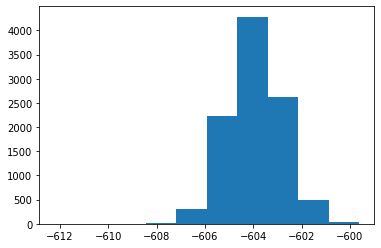

In [44]:
plt.hist(zPrime.detach().numpy().ravel())

(array([3.200e+01, 4.860e+02, 2.625e+03, 4.284e+03, 2.231e+03, 3.080e+02,
        2.200e+01, 3.000e+00, 3.000e+00, 6.000e+00]),
 array([35.770107, 35.845406, 35.9207  , 35.996   , 36.071297, 36.14659 ,
        36.22189 , 36.297188, 36.372486, 36.44778 , 36.52308 ],
       dtype=float32),
 <a list of 10 Patch objects>)

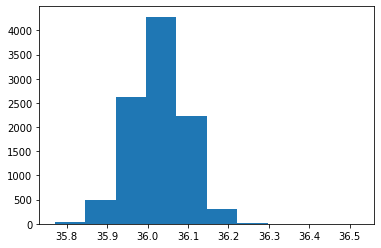

In [45]:
plt.hist(xHat.detach().numpy().ravel())